In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
from os.path import expanduser
from pandas import read_csv
from pandas import DataFrame
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from numpy import array, add, divide
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords

## Import data

In [3]:
home = expanduser('~')
my_path = f'{home}/Downloads/project_mining_2022/dataset/amazon.csv'

In [4]:
reviews = read_csv(my_path)
reviews.columns = ['text_review', 'rating']
reviews.head()

,text_review,rating
0,The description and photo on this product need...,3
1,This was a great book!!!! It is well thought t...,5
2,"I am a first year teacher, teaching 5th grade....",5
3,I got the book at my bookfair at school lookin...,5
4,Hi! I'm Martine Redman and I created this puzz...,5


## Preproccessing

### Noise Removal, Lowercasing and Normalization

In [5]:
reviews['text_review'] = reviews['text_review'].map(simple_preprocess)
reviews.head()

,text_review,rating
0,"[the, description, and, photo, on, this, produ...",3
1,"[this, was, great, book, it, is, well, thought...",5
2,"[am, first, year, teacher, teaching, th, grade...",5
3,"[got, the, book, at, my, bookfair, at, school,...",5
4,"[hi, martine, redman, and, created, this, puzz...",5


### Stop words removal [maybe Stemming, Lemmatization, Stopword Removal?]

In [6]:
def remove_stopwords(sentence_as_list):
    stop_words = set(stopwords.words('english'))
    return [word for word in sentence_as_list if word not in stop_words]
            
            
reviews['text_review'] = reviews['text_review'].map(remove_stopwords)
reviews.head()

,text_review,rating
0,"[description, photo, product, needs, changed, ...",3
1,"[great, book, well, thought, easily, imagine, ...",5
2,"[first, year, teacher, teaching, th, grade, sp...",5
3,"[got, book, bookfair, school, looking, somethi...",5
4,"[hi, martine, redman, created, puzzle, briarpa...",5


In [7]:
# remove blanks
reviews = reviews[reviews['text_review'].map(len) > 0]

In [8]:
text_reviews = reviews['text_review'].values
Y = reviews['rating'].values

## Create and model with Word2Vec

In [9]:
model = Word2Vec(
    window=5,
    min_count=1,
    workers=4
)
model.build_vocab(text_reviews, progress_per=1000)

In [10]:
model.train(text_reviews, total_examples=model.corpus_count, epochs=model.epochs)

(8891313, 9327490)

In [11]:
model.save('./amazon_reviews_trained_word2vec')

In [12]:
model.wv.most_similar('good')

[('decent', 0.7805057168006897),
 ('great', 0.750182569026947),
 ('ok', 0.677306592464447),
 ('bad', 0.6615262627601624),
 ('okay', 0.6282117366790771),
 ('reasonable', 0.6282050013542175),
 ('fantastic', 0.6220912933349609),
 ('excellent', 0.6184373497962952),
 ('wise', 0.6021673679351807),
 ('awesome', 0.594153106212616)]

In [13]:
model.wv.similarity(w1='great', w2='awesome')

0.7229675

### Pair words to embeddings

In [14]:
word_vec = dict({})
for key in model.wv.index_to_key:
    word_vec[key] = model.wv[key]

### Create document vectors

In [15]:
docVec = []
# for every review
for i in range(len(text_reviews)):
    sentVect = array(100)
    # for each word in review
    for j in range(len(text_reviews[i])):
        word = text_reviews[i][j]
        if word in word_vec.keys():
            # vector addition of the words in the text
            sentVect = add(sentVect, word_vec[word])
            
    # normalize vector
    sentVect = divide(sentVect, len(text_reviews[i]))
    docVec.append(sentVect)

In [16]:
doc_vectors = DataFrame(docVec)
doc_vectors['rating'] = Y
doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,rating
0,8.986559,9.803274,8.769523,8.829211,9.303893,8.926492,9.001976,10.333488,9.006742,9.099776,...,8.852845,8.859558,8.942059,9.433333,9.144350,9.345303,8.607111,9.140155,9.131814,3
1,4.004692,4.545535,3.436692,4.260720,3.710545,3.663581,4.106510,4.526963,3.464768,3.709066,...,4.301771,3.151076,3.810423,4.377810,3.561296,4.236473,3.598867,3.968994,3.860459,5
2,1.996457,2.559013,1.754743,2.121185,2.004411,1.523626,1.943274,2.363454,1.501353,1.642485,...,2.298318,1.547433,1.743775,2.113623,2.029410,2.110367,1.778512,1.432950,1.813241,5
3,2.383894,2.703706,1.874210,2.662862,1.972716,2.121916,2.457296,2.764375,1.744975,2.106588,...,2.522181,2.112277,2.117678,2.251608,2.219999,2.569147,2.007192,1.976601,2.107385,5
4,1.530847,1.918497,1.268671,1.653742,1.505481,1.442893,1.580122,2.015061,1.413939,1.373301,...,1.776438,1.091131,1.396433,1.618471,1.618182,1.853767,1.352942,1.234549,1.662124,5


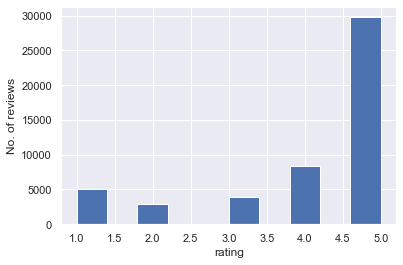

In [17]:
plt.hist(doc_vectors['rating'])
plt.xlabel('rating')
plt.ylabel('No. of reviews')
plt.show()

## Give them as input to a random forest

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_doc_vectors = DataFrame(scaler.fit_transform(doc_vectors.drop(['rating'], axis=1)))

In [19]:
scaled_doc_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.688851,0.731199,0.656798,0.616111,0.736759,0.740287,0.626639,0.778379,0.761373,0.731774,...,0.538967,0.613667,0.734620,0.672430,0.682510,0.728151,0.688233,0.676744,0.653470,0.727374
1,-0.121625,-0.122630,-0.215273,-0.131453,-0.177717,-0.119048,-0.173422,-0.164379,-0.138446,-0.151514,...,-0.161973,-0.129416,-0.199425,-0.165827,-0.140559,-0.182256,-0.145447,-0.141886,-0.190942,-0.135626
2,-0.448335,-0.445231,-0.490321,-0.481556,-0.456658,-0.468462,-0.526957,-0.515651,-0.457234,-0.490131,...,-0.474835,-0.456533,-0.461820,-0.503415,-0.509182,-0.432055,-0.492394,-0.439435,-0.605059,-0.470786
3,-0.385304,-0.421734,-0.470784,-0.392919,-0.461840,-0.370773,-0.442951,-0.450557,-0.417679,-0.414086,...,-0.422906,-0.419981,-0.369398,-0.442338,-0.486717,-0.400976,-0.417528,-0.402055,-0.516285,-0.422630
4,-0.524082,-0.549247,-0.569807,-0.558046,-0.538230,-0.481645,-0.586306,-0.572217,-0.471427,-0.534238,...,-0.597410,-0.541743,-0.536482,-0.560154,-0.589795,-0.499112,-0.534267,-0.508997,-0.637457,-0.495526


In [20]:
X_train, X_test, y_train, y_test = train_test_split(scaled_doc_vectors, doc_vectors['rating'], test_size=0.2)

In [21]:
randomForest = RandomForestClassifier(n_estimators=30, random_state=24)
randomForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=24)

In [22]:
randomForest.score(X_test, y_test)

0.6131613161316132

In [23]:
y_pred = randomForest.predict(X_test)

### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 208,   10,    7,   43,  736],
       [  42,   18,    1,   46,  466],
       [  47,    6,   19,   63,  628],
       [  49,    3,   11,  116, 1508],
       [  53,    5,   18,  126, 5770]], dtype=int64)

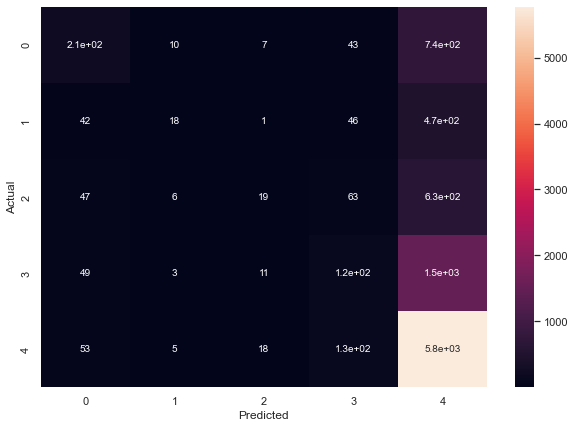

In [25]:
%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

###  f1 score, precision and recall 

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average='micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Precision: 0.613
Recall: 0.613
F1 Score: 0.613
Accuracy: 0.613


In [27]:
# bias data to 5 rating